# 《统计方法与机器学习》实践作业4

10211900416 郭夏辉

## D-Day： Nov. 8th
## 任务：

### 数据预处理
1. 从scikit-learn包中载入数据集diabetes

2. 通过阅读以下参考文献，定义清楚问题背景、数据中响应变量和自变量的概念、取值范围等信息。

3. 以学号的最后三位数字作为随机种子，采用留出法划分训练集和测试集，样本比例为7.5:2.5。

### 模型构建
在本次实验中我们将a quantitative measure of disease progression one year after baseline作为响应变量，构建合适的特征（可参考文献2），并训练模型。

4. 判断用于建模的特征数据中是否存在多重共线性？提供合适的判断方案。

5. 构建线性回归模型Model_1、岭回归模型Model_2、主成分回归模型Model_3。

### 模型评价

6. 利用RMSE，比较Model_1、Model_2、Model_3在测试集上的预测效果。请进行评论。


### 参考文献：
[1] https://scikit-learn.org/stable/datasets/toy_dataset.html

[2] https://www4.stat.ncsu.edu/~boos/var.select/diabetes.html

## 1.从scikit-learn包中载入数据集diabetes

In [16]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import math

from sklearn import preprocessing # Data Preprocessing
import statsmodels.api as sm # LSE, Ridge Regression
from statsmodels.stats.outliers_influence import variance_inflation_factor # VIF 
from statsmodels.multivariate.pca import PCA # PCR

from sklearn.datasets import load_diabetes
data = load_diabetes(scaled=False)

## 2.通过阅读以下参考文献，定义清楚问题背景、数据中响应变量和自变量的概念、取值范围等信息。

In [9]:
data

{'data': array([[59.    ,  2.    , 32.1   , ...,  4.    ,  4.8598, 87.    ],
        [48.    ,  1.    , 21.6   , ...,  3.    ,  3.8918, 69.    ],
        [72.    ,  2.    , 30.5   , ...,  4.    ,  4.6728, 85.    ],
        ...,
        [60.    ,  2.    , 24.9   , ...,  3.77  ,  4.1271, 95.    ],
        [36.    ,  1.    , 30.    , ...,  4.79  ,  5.1299, 85.    ],
        [36.    ,  1.    , 19.6   , ...,  3.    ,  4.5951, 92.    ]]),
 'target': array([151.,  75., 141., 206., 135.,  97., 138.,  63., 110., 310., 101.,
         69., 179., 185., 118., 171., 166., 144.,  97., 168.,  68.,  49.,
         68., 245., 184., 202., 137.,  85., 131., 283., 129.,  59., 341.,
         87.,  65., 102., 265., 276., 252.,  90., 100.,  55.,  61.,  92.,
        259.,  53., 190., 142.,  75., 142., 155., 225.,  59., 104., 182.,
        128.,  52.,  37., 170., 170.,  61., 144.,  52., 128.,  71., 163.,
        150.,  97., 160., 178.,  48., 270., 202., 111.,  85.,  42., 170.,
        200., 252., 113., 143.,  51

In [17]:
print(data['feature_names'])

print("特征数：",data['data'].shape[1])
print("样本量：",data['data'].shape[0])

['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']
特征数： 10
样本量： 442


通过阅读参考文献，我们可以得知发现这个数据集中自变量有十个，分别是：

年龄、性别、BMI指数、平均血压、s1血清总胆固醇、s2低密度脂蛋白、s3高密度脂蛋白、s4总胆固醇、s5血清甘油三酯、s6血糖

响应变量是病人一年后的糖尿病发展情况。

样本量$n=442$

研究的是病人的生理数据与一年后病情发展情况之间的关系。

## 3.以学号的最后三位数字作为随机种子，采用留出法划分训练集和测试集，样本比例为7.5:2.5。

在本次实验中我们将a quantitative measure of disease progression one year after baseline作为响应变量，构建合适的特征（可参考文献2），并训练模型。

In [18]:
df = pd.DataFrame(data['data'], columns=data['feature_names'])
df['trend'] = data['target']
df.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,trend
0,59.0,2.0,32.1,101.0,157.0,93.2,38.0,4.0,4.8598,87.0,151.0
1,48.0,1.0,21.6,87.0,183.0,103.2,70.0,3.0,3.8918,69.0,75.0
2,72.0,2.0,30.5,93.0,156.0,93.6,41.0,4.0,4.6728,85.0,141.0
3,24.0,1.0,25.3,84.0,198.0,131.4,40.0,5.0,4.8903,89.0,206.0
4,50.0,1.0,23.0,101.0,192.0,125.4,52.0,4.0,4.2905,80.0,135.0


In [19]:
seed = 416
p = 10 # 特征数
n = 442 # 样本量

n_train=int(n*0.75)
n_test = n - n_train

random.seed(seed)
index_selected = random.sample(range(0,n),n_train)
index_selected.sort()

# 划分训练集和测试集
data_train = df.loc[index_selected]
data_test = df.drop(index = index_selected)

然后，我对自变量进行标准化，对响应变量进行中心化，并试着建立一个线性回归模型。

In [20]:
# 响应变量和自变量
X_train = data_train.drop(columns = ['trend'],axis = 1)
y_train = data_train['trend']

X_test = data_test.drop(columns = ["trend"],axis=1)
y_test = data_test['trend']

# 对自变量标准化，对响应变量中心化
X_train_standardized = preprocessing.scale(X_train, with_mean = True, with_std=True)/np.sqrt(n_train)
y_train_centered = preprocessing.scale(y_train, with_mean = True, with_std=False)
y_train_mean = np.average(y_train)
X_test_standardized = preprocessing.scale(X_test, with_mean = True, with_std=True)/np.sqrt(n_test)

#建立线性回归模型
X_train_withintercept = sm.add_constant(X_train)
model = sm.OLS(y_train,X_train_withintercept).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  trend   R-squared:                       0.554
Model:                            OLS   Adj. R-squared:                  0.540
Method:                 Least Squares   F-statistic:                     39.71
Date:                Sat, 04 Nov 2023   Prob (F-statistic):           2.38e-50
Time:                        23:32:18   Log-Likelihood:                -1779.2
No. Observations:                 331   AIC:                             3580.
Df Residuals:                     320   BIC:                             3622.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -273.1857     79.202     -3.449      0.001    -429.008    -117.363
age           -0.0820      0.246     -0.333      0.739      -0.566       0.402
sex          -22.7069      6.531     -3.477      0.001     -35.555      -9.859
bmi            6.1158      0.815      7.508      0.000       4.513       7.718
bp             0.8221      0.261      3.154      0.002       0.309       1.335
s1            -0.5197      0.664     -0.782      0.435      -1.827       0.787
s2             0.2341      0.606      0.386      0.699      -0.958       1.426
s3            -0.2813      0.920     -0.306      0.760      -2.091       1.529
s4             6.1964      6.894      0.899      0.369      -7.368      19.761
s5            55.6786     17.871      3.116      0.002      20.519      90.838
s6             0.2612      0.314      0.832      0.406      -0.357       0.879
==============================================================================
Omnibus:                        1.669   Durbin-Watson:                   1.964
Prob(Omnibus):                  0.434   Jarque-Bera (JB):                1.491
Skew:                          -0.027   Prob(JB):                        0.474
Kurtosis:                       2.676   Cond. No.                     7.46e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.46e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## 4.判断用于建模的特征数据中是否存在多重共线性？提供合适的判断方案。

<Axes: >

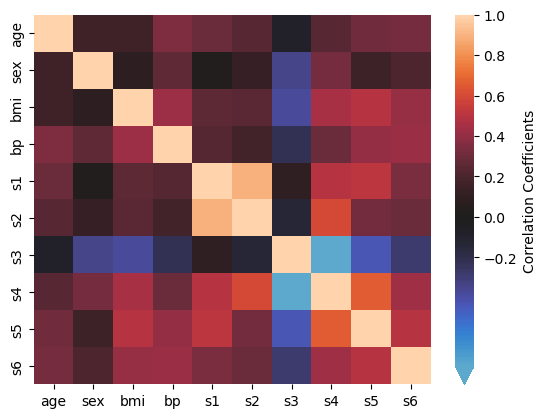

In [21]:
pcorr = X_train.corr(method = 'pearson')
tick_ = (np.arange(0,13,2)-2)/10
dict_ = {"orientation":'vertical',
         'label':'Correlation Coefficients',
         "drawedges":False,
         "ticklocation":"top",
         "extend":"min",
        "filled":True,
         "alpha":0.8,
         "cmap":"cmap",
         "ticks":tick_}
sns.heatmap(pcorr,cbar_kws= dict_,center=0)

在热力图中，某格子颜色越浅说明这两个自变量之间的线性相关程度越大。

观察可得，$s1$与$s2$、$s3$与$s4$、$s4$与$s5$对应格子的颜色较浅，这几对变量可能线性相关。

数据中可能存在多重共线性，但总体来说程度应该并不严重。

接下去我再用方差扩大因子法来检验数据中是否存在多重共线性。

记$\mathbf{X_s}$为标准化后的自变量，则矩阵$(\mathbf{X_s}^T\mathbf{X_s})^{-1}$的第$j$个对角线元素$c_{jj}$就是第$j$个自变量$x_{j}$的方差扩大因子。

事实上，如果我们把$x_{j}$作为响应变量，其它自变量作为自变量建立线性回归模型，记$R_j$为其复决定系数，可以证明$$c_{jj}=\frac{1}{1-R_j^2}$$由于$R_j$衡量$x_{j}$与其它自变量之间的线性相关性，$R_j$越大，方差扩大因子$c_{jj}$越大，自变量$x_{j}$与其它自变量的多重共线性就越严重。

综上所述，只要这个方差扩大因子大于某一个特定的值(这里设为$5$)，我们就认为$x_j$与其它自变量之间存在多重共线性。

下面，我们就来计算一下各个自变量的方差扩大因子。

In [22]:
C = np.linalg.inv(np.dot(X_train_standardized.T,X_train_standardized))
VIF_1 = np.diag(C)
print("The VIF's are", np.round(VIF_1,2))

The VIF's are [ 1.25  1.24  1.59  1.51 57.98 34.8  16.53  8.45 10.55  1.55]


也可以这样来计算方差扩大因子：

In [23]:
VIF_2 = [variance_inflation_factor(X_train_standardized[:,0:p], i) for i in range(p)]
print("The VIF's are", np.round(VIF_2,2))

The VIF's are [ 1.25  1.24  1.59  1.51 57.98 34.8  16.53  8.45 10.55  1.55]


还可以利用理论作业证明过的结论，即$\text{VIF}_j = \frac{1}{1-R_j^2}$来求解：

In [44]:
X1 = X_train_standardized[:,0]
X2 = X_train_standardized[:,1:p]
model_vif = sm.OLS(X1,X2).fit()
X_1_VIF = 1/(1-model_vif.rsquared)
print("The VIF of the first feature is", np.round(X_1_VIF,2))

The VIF of the first feature is 1.25


在以上十个方差扩大因子中，$s1$和$s2$的方差扩大因子明显大于其它自变量的，也大于我们设定的临界值$5$。

因此，我们认为用于建模的特征数据中存在多重共线性。

然后我再用特征值法来判断数据中是否存在多重共线性。

当某些自变量之间存在线性相关，$$\mathbf{X_s}^T\mathbf{X_s}\approx 0$$所以$\mathbf{X_s}^T\mathbf{X_s}$必然有一些特征值非常接近于零。我们将自变量矩阵的条件数记为最大特征值比最小特征值的算数平方根，即$$\kappa=\sqrt{\frac{\lambda_1}{\lambda_p}}$$

这个条件数越大，就说明自变量的多重共线性就越严重。

所以，当条件数大于某个特定的值，我们就认为自变量之间存在多重共线性。


In [24]:
#计算特征值
R = np.dot(X_train_standardized.T,X_train_standardized)
W, V = np.linalg.eig(R)
W = -1* np.sort(-1*W)
W_diag = np.diag(W)
V = V.T
print("The eigen values are", np.round(W,4))

The eigen values are [4.0729 1.5784 1.123  0.974  0.6887 0.5686 0.4683 0.4309 0.0864 0.0088]


In [25]:
Condition_Number = np.sqrt(np.max(W)/np.min(W))
print("The condition number is",np.round(Condition_Number,4))

The condition number is 21.4921


条件数的临界值通常为$10$，$100$或$1000$。

如果临界值设置得比较小，我们就会认为这个模型存在多重共线性。

我定义临界值为$10$,因为条件数大于临界值，故认为这个模型的自变量之间存在多重共线性。

## 5.构建线性回归模型Model_1、岭回归模型Model_2、主成分回归模型Model_3。

### 岭回归

在岭回归模型中，我们对矩阵$\mathbf{X^TX}$加上$k\mathbf{I}$，从而使得得到的矩阵与原来的$\mathbf{X^TX}$差别不大，并避免$\mathbf{X^TX}$奇异。最终，我们得到的岭回归值就是$$\hat{\beta(k)}=(\mathbf{X^TX}+k\mathbf{I})^{-1}\mathbf{X^Ty}$$
显然，这个岭回归值是超参数$k$的函数。所以，我们首先要确定$k$的值，使得我们得到的岭回归值最优。我们来绘制岭迹图：

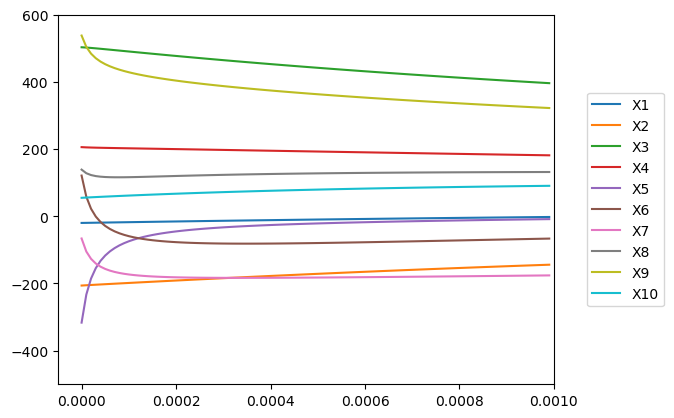

In [27]:
alpha_num = 100
alpha_vec = np.array(list(range(0,alpha_num)))/alpha_num/1000
RR_coef = []
RR_vif = []
alpha  = 0.1

for alpha in alpha_vec:
    rr_model = sm.OLS(y_train_centered,X_train_standardized).fit_regularized(L1_wt=0,alpha = alpha)
    rr_coef = rr_model.params
    RR_coef.append(rr_coef)
for i in range(p):
    plt.plot(alpha_vec, np.array(RR_coef)[:,i],label = "X%d"%(i+1))

plt.axis([-0.00005,0.001,-500,600])    
plt.legend(loc="right",bbox_to_anchor=(1.25,0.5),borderaxespad=1)

实际上，岭迹就是岭估计$\hat{\beta(k)}$中的各个分量，岭迹图就是岭迹与$k$之间的函数图像。

我们需要观察$k$为何值时各个回归系数的岭估计趋于稳定且符号合理。

但是这种方法完全依靠对图像的观察，太过主观。所以，我们用方差扩大因子法确定最优的超参数$k$。

这里我们用方差扩大因子法，找到合适的$k$使得岭估计的方差扩大因子都小于某个特定的值，并由这个$k$值得到$\beta$的岭回归估计。

In [29]:
#找到最优的超参数
vif_cv = 5
C_k = []
for alpha in alpha_vec:
    k = alpha * n_train
    c_k = np.linalg.inv(X_train_standardized.T @ X_train_standardized + k * np.eye(p)) @ X_train_standardized.T @ X_train_standardized @ np.linalg.inv(X_train_standardized.T @ X_train_standardized + k * np.eye(p))
    C_k.append(np.mean(np.diag(c_k)))


alpha_best = alpha_vec[np.min(np.where(np.array(C_k) < vif_cv))]
print("The best alpha is", alpha_best)
#根据这个最优的超参数进行岭估计
model_rr_best = sm.OLS(y_train_centered,X_train_standardized).fit_regularized(L1_wt=0,alpha = alpha_best)
model_rr_best_coef = model_rr_best.params
print("The parameters in the ridge regression are ",np.round(model_rr_best.params,2))

The best alpha is 2.9999999999999997e-05
The parameters in the ridge regression are  [ -19.13 -203.68  499.8   204.21 -154.47   -0.74 -140.48  119.62  470.45
   57.16]


### 主成分回归

接下来我们再来构建主成分回归模型。

主成分回归的思想就是，用更少的、线性无关的自变量来代替原来存在多重共线性的自变量，并构建线性回归模型。新的自变量组合要包含原来的自变量所携带的绝大部分信息。

如果一个主成分还不足以代表绝大部分原来的自变量的信息，我们要寻找更多的主成分。

最终要找多少个主成分，是主成分回归中的超参数。我们应该先来确定这个超参数。

通过观察每添加一个主成分之后信息量增加了多少，来直观判断到底要不要继续添加主成分。

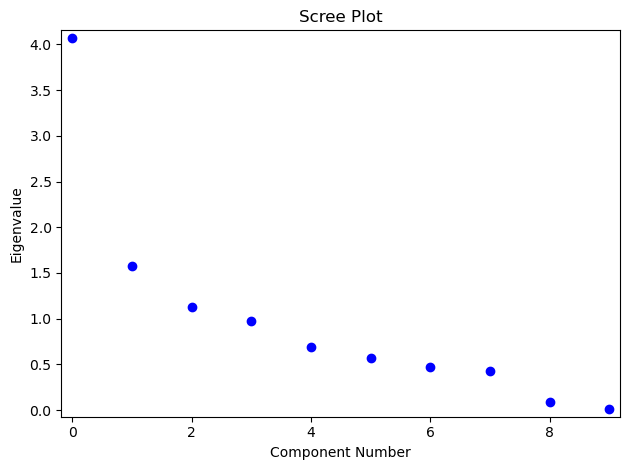

In [30]:
# 计算特征值
model_pca = PCA(X_train_standardized,standardize = False, demean = True)
model_pca_cr = model_pca.eigenvals
# 计算信息增量，计算累计贡献率
model_pca_ccr = np.cumsum(model_pca_cr)/p 
fig = model_pca.plot_scree(log_scale = False)

可见，在添加了第8个主成分之后再继续添加，信息量的增量就近乎于零了。

接着，我们来精确地计算添加几个主成分，主成分的信息贡献率之和能够达到某个特定的值（如$0.95$）。

In [34]:
pca_cv = 0.95
num_pca = np.min(np.where(model_pca_ccr > pca_cv))
print("The appropriate number of component is", (num_pca+1))

The appropriate number of component is 8


可见，我们只需要添加八个主成分就足以得到原来的自变量的绝大多数信息了。

这和刚刚的直观判断一致。接着，我们构建八个主成分并将它们作为自变量构建线性回归模型，求出参数的估计值：

In [36]:
model_pca_selected = PCA(X_train_standardized,  standardize = False,  demean = True)
V = model_pca_selected.loadings
Z_train_standardized= X_train_standardized @ V[:,0:(num_pca+1)]
model_pcr = sm.OLS(y_train_centered, Z_train_standardized).fit()
model_pcr_coef = V.T @ np.pad(model_pcr.params,(0,p-(num_pca+1)))
print(model_pcr_coef)

[-136.49522183  168.42164775   51.28339556  -26.8768207   641.23815335
  142.50413339 -161.00098755  183.08636922  193.76510573   53.03085155]


## 6.利用RMSE，比较Model_1、Model_2、Model_3在测试集上的预测效果。请进行评论。

最后，我们就要在训练集上检验以上三种模型的预测效果了，评判的指标是训练集预测值和训练集真实值之间的均方误差$$RMSE = \sqrt{\frac{1}{n}\sum_{i=1}^n (\hat{y}_i - y_i)^2}$$显然，当$RMSE$越小，该模型预测的准确度越高。


### 线性回归模型

In [38]:
model_ols = sm.OLS(y_train_centered,X_train_standardized).fit()
model_ols_coef = model_ols.params 
y_pred_ols = y_train_mean + X_test_standardized @ model_ols_coef
ols_rmse = np.sqrt(np.mean((y_pred_ols-y_test)**2))
print("The RMSE in the ordinary regression is", round(ols_rmse,4))

The RMSE in the ordinary regression is 72.2477


### 岭回归模型

In [40]:
y_pred_rr = y_train_mean + X_test_standardized @ model_rr_best_coef
rr_rmse = np.sqrt(np.mean((y_pred_rr-y_test)**2))
print("The RMSE in the ridge regression is", round(rr_rmse,4))

The RMSE in the ridge regression is 72.209


### 主成分回归模型

In [41]:
y_pred_pcr = y_train_mean + X_test_standardized @ model_pcr_coef
pcr_rmse = np.sqrt(np.mean((y_pred_pcr-y_test)**2))
print("The RMSE in the ordinary regression is", round(pcr_rmse,4))

The RMSE in the ordinary regression is 111.1978


我们看到，岭回归模型的$RMSE$值最小，线性回归模型的$RMSE$略大于岭回归模型的，而主成分回归模型的$RMSE$显著大于另外两者。可见在这个数据集上最好还是不要使用主成分回归模型，而且岭回归模型的优势并不明显。

如果要说我的猜想，我觉得可能是因为这个数据集多重共线性程度不算高，就没有很大的必要去用几个主成分去替代原来的自变量了。十个因素都会对模型提供一定量的信息，删去其中的一些有信息丢失的风险。

然后，岭回归估计和线性回归模型类似的原因可能在于$\mathbf{X^TX}+k\mathbf{I}$与$\mathbf{X^TX}$的差别不算大。